In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [2]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve, precision_score, recall_score
from statistics import mean
from src.utils import utils, evaluation_utils, visualization_utils

In [4]:
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv.csv")

In [5]:
def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    print(labels_counts)
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n(n={int(v/100*n)}, {v:.3f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [6]:
dataset_df = pd.read_csv(dataset_file_path)

In [7]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=True)
metadata_formatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 'Homo sapiens\n(n=218631, 99.347%)',
 'Macaca mulatta': 'Macaca mulatta\n(n=849, 0.386%)',
 'Felis catus': 'Felis catus\n(n=143, 0.065%)',
 'Cercocebus atys': 'Cercocebus atys\n(n=122, 0.055%)',
 'Puma concolor': 'Puma concolor\n(n=24, 0.011%)',
 'Macaca nemestrina': 'Macaca nemestrina\n(n=23, 0.010%)',
 'Mandrillus sphinx': 'Mandrillus sphinx\n(n=23, 0.010%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus\n(n=20, 0.009%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans\n(n=19, 0.009%)',
 'Cercopithecus solatus': 'Cercopithecus solatus\n(n=17, 0.008%)',
 'Cercocebus torquatus': 'Cercocebus torquatus\n(n=16, 0.007%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops\n(n=14, 0.006%)',
 'Cercopithecus cephus': 'Cercopithecus cephus\n(n=13, 0.006%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus\n(n=13, 0.006%)',
 'Colobus guereza': 'Colobus guereza\n(n=13, 0.006%)',
 'Panthera leo': 'Panthera leo\n(n=12, 0.005%)',
 'Cercopithecus neglectus': 'Cercopithecus neg

In [8]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=False)
metadata_unformatted

Homo sapiens                          218631
Macaca mulatta                           849
Felis catus                              143
Cercocebus atys                          122
Puma concolor                             24
Macaca nemestrina                         23
Mandrillus sphinx                         23
Mandrillus leucophaeus                    20
Cercopithecus nictitans                   19
Cercopithecus solatus                     17
Cercocebus torquatus                      16
Cercopithecus aethiops                    14
Cercopithecus cephus                      13
Chlorocebus sabaeus                       13
Colobus guereza                           13
Panthera leo                              12
Cercopithecus neglectus                   12
Cercopithecus mona                        10
Chlorocebus tantalus                      10
Felis silvestris catus                     9
Cercopithecus lhoesti                      8
Chlorocebus pygerythrus                    7
Cercopithe

{'Homo sapiens': 99.34702001199629,
 'Macaca mulatta': 0.3857898467746333,
 'Felis catus': 0.0649799152989076,
 'Cercocebus atys': 0.05543741025501209,
 'Puma concolor': 0.010905720050166313,
 'Macaca nemestrina': 0.01045131504807605,
 'Mandrillus sphinx': 0.01045131504807605,
 'Mandrillus leucophaeus': 0.009088100041805259,
 'Cercopithecus nictitans': 0.008633695039714997,
 'Cercopithecus solatus': 0.007724885035534471,
 'Cercocebus torquatus': 0.0072704800334442085,
 'Cercopithecus aethiops': 0.0063616700292636824,
 'Cercopithecus cephus': 0.005907265027173419,
 'Chlorocebus sabaeus': 0.005907265027173419,
 'Colobus guereza': 0.005907265027173419,
 'Panthera leo': 0.005452860025083156,
 'Cercopithecus neglectus': 0.005452860025083156,
 'Cercopithecus mona': 0.0045440500209026295,
 'Chlorocebus tantalus': 0.0045440500209026295,
 'Felis silvestris catus': 0.004089645018812368,
 'Cercopithecus lhoesti': 0.0036352400167221043,
 'Chlorocebus pygerythrus': 0.0031808350146318412,
 'Cercopit

In [9]:
classes = list(metadata_unformatted.keys())
classes

['Homo sapiens',
 'Macaca mulatta',
 'Felis catus',
 'Cercocebus atys',
 'Puma concolor',
 'Macaca nemestrina',
 'Mandrillus sphinx',
 'Mandrillus leucophaeus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Cercopithecus cephus',
 'Chlorocebus sabaeus',
 'Colobus guereza',
 'Panthera leo',
 'Cercopithecus neglectus',
 'Cercopithecus mona',
 'Chlorocebus tantalus',
 'Felis silvestris catus',
 'Cercopithecus lhoesti',
 'Chlorocebus pygerythrus',
 'Cercopithecus mitis',
 'Cercopithecus erythrotis',
 'Felis domesticus',
 'Macaca arctoides',
 'Macaca fascicularis',
 'Semnopithecus entellus',
 'Bos taurus',
 'Miopithecus ogouensis',
 'Cercopithecus ascanius',
 'Cercocebus torquatus atys',
 'Lynx rufus',
 'Cercopithecus aethiops pygerythrus',
 'Piliocolobus tephrosceles',
 'Piliocolobus badius',
 'Otocolobus manul',
 'Panthera pardus',
 'Papio ursinus',
 'Procolobus verus']

In [10]:
classes_order = {k:i for i, k in enumerate(classes)}
class_formatted_order = {val: classes_order[key] for key, val in metadata_formatted.items()}
print(classes_order)
print(class_formatted_order)

{'Homo sapiens': 0, 'Macaca mulatta': 1, 'Felis catus': 2, 'Cercocebus atys': 3, 'Puma concolor': 4, 'Macaca nemestrina': 5, 'Mandrillus sphinx': 6, 'Mandrillus leucophaeus': 7, 'Cercopithecus nictitans': 8, 'Cercopithecus solatus': 9, 'Cercocebus torquatus': 10, 'Cercopithecus aethiops': 11, 'Cercopithecus cephus': 12, 'Chlorocebus sabaeus': 13, 'Colobus guereza': 14, 'Panthera leo': 15, 'Cercopithecus neglectus': 16, 'Cercopithecus mona': 17, 'Chlorocebus tantalus': 18, 'Felis silvestris catus': 19, 'Cercopithecus lhoesti': 20, 'Chlorocebus pygerythrus': 21, 'Cercopithecus mitis': 22, 'Cercopithecus erythrotis': 23, 'Felis domesticus': 24, 'Macaca arctoides': 25, 'Macaca fascicularis': 26, 'Semnopithecus entellus': 27, 'Bos taurus': 28, 'Miopithecus ogouensis': 29, 'Cercopithecus ascanius': 30, 'Cercocebus torquatus atys': 31, 'Lynx rufus': 32, 'Cercopithecus aethiops pygerythrus': 33, 'Piliocolobus tephrosceles': 34, 'Piliocolobus badius': 35, 'Otocolobus manul': 36, 'Panthera pardu

In [11]:
dataset_df["virus_host_name"].nunique()

40

In [12]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

In [59]:
def get_rank(row, all_output_labels):
    y_true = row["y_true"]
    ranks = row[all_output_labels].rank(ascending=False, method="min")
    return ranks[y_true]

def get_rank_bin(row):
    rank = row["y_true_rank"]
    if rank == 1:
        return "Correct Prediction"
    elif rank <= 3:
        return "Top 3 ranks"
    elif rank <= 5:
        return "Top 5 ranks"
    elif rank <= 7:
        return "Top 7 ranks"
    elif rank <= 10:
        return "Top 10 ranks"
    else:
        return "Rank > 10"

def plot_rank_distribution(df):
    plt.clf()
    plt.figure(figsize=(10, 10))
    sns.set_theme()
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams.update({'font.size': 16})
    ax = sns.histplot(df, x="y_true_rank", hue="y_true",  fill=True)
    ax.set_xlabel("Rank based on Probability", fontsize=20)
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1.3, 1))

   # plt.legend(title="Classes", loc="upper right", fontsize=10)
    plt.show()

    
def plot_probability_distribution(class_prob_df, random_predictor):
    plt.clf()
    plt.figure(figsize=(15, 15))
    sns.set_theme()
    plt.rcParams['xtick.labelsize'] = 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams.update({'font.size': 16})
    #ax = sns.violinplot(data=class_prob_df, x="probability", y="class", orient="h", hue="y_pred_tag", fill=False, split=True, gap=.1)
    class_prob_df.sort_values(by="class", key=lambda x: x.map(class_formatted_order), inplace=True)
    ax = sns.swarmplot(class_prob_df, x="probability", y="class", hue="y_true_rank_bin", orient="h")

    ax.axvline(random_predictor, color="gray", linestyle="--")
    ax.set_ylabel("Classes", fontsize=20)
    ax.set_xlabel("Probability", fontsize=20)
    sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 1))
    plt.legend(title="Prediction", loc="upper right", fontsize=16)
    plt.show()
    
    
def analyze_all_way_fsl_results(output_file_path, auprc_file_path):
    output_auprc_df = pd.read_csv(auprc_file_path, index_col=0)
    output_df = pd.read_csv(output_file_path, index_col=0)
    print(f"Number of unique classes in output_df = {output_auprc_df['class'].nunique()}")
    
    all_output_labels = list(output_df.columns)
    all_output_labels.remove("itr")
    all_output_labels.remove("y_true")
    print(f"Number of unique labels in output_df = {len(all_output_labels)}")
    
    sub_df = output_df#[output_df["itr"] == 0]
    sub_df.drop(columns="itr", inplace=True)
    sub_df["y_true_rank"] = sub_df.apply(lambda x: get_rank(x, all_output_labels), axis=1)
    sub_df["y_true_rank_bin"] = sub_df.apply(get_rank_bin, axis=1)
    
    plot_rank_distribution(sub_df.replace({"y_true": metadata_formatted}))
    
    
    idv_labels_in_output = set(metadata_unformatted.keys()).intersection(set(all_output_labels))
    print(f"Number of IDV labels in output - {len(idv_labels_in_output)}")
    print(idv_labels_in_output)
    
    output_df["y_pred"] = output_df[all_output_labels].idxmax(axis=1)
        
    classwise_prob_dfs = []
    
    for label in idv_labels_in_output:
        
        class_prob_df = sub_df[[label, "y_true", "y_true_rank_bin", "y_true_rank"]][sub_df["y_true"] == label]
        class_prob_df = class_prob_df.rename(columns={label: "probability", "y_true": "class"})
        classwise_prob_dfs.append(class_prob_df)
    class_prob_df = pd.concat(classwise_prob_dfs)
    print(class_prob_df.head())
    class_prob_df.replace({"class": metadata_formatted}, inplace=True)
    
    plot_probability_distribution(class_prob_df, 1/len(all_output_labels))
    return class_prob_df


### Unseen hosts

#### 167-way

In [60]:
output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w3s5q10_ev_walls5q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")


Number of unique classes in output_df = 167
Number of unique labels in output_df = 167


<Figure size 432x288 with 0 Axes>

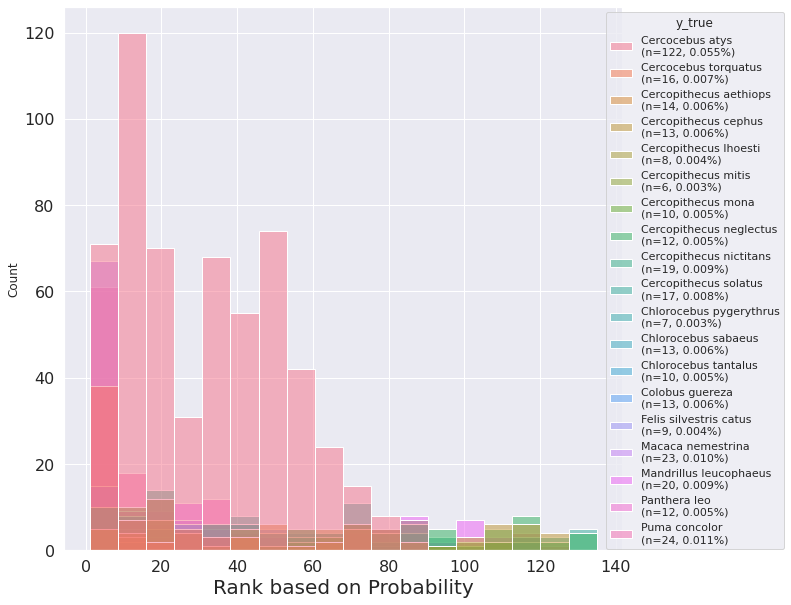

Number of IDV labels in output - 27
{'Cercocebus atys', 'Cercopithecus nictitans', 'Colobus guereza', 'Chlorocebus tantalus', 'Cercocebus torquatus', 'Chlorocebus sabaeus', 'Cercopithecus cephus', 'Mandrillus sphinx', 'Macaca nemestrina', 'Macaca fascicularis', 'Cercopithecus neglectus', 'Felis silvestris catus', 'Mandrillus leucophaeus', 'Cercopithecus mona', 'Puma concolor', 'Bos taurus', 'Cercopithecus mitis', 'Panthera leo', 'Macaca mulatta', 'Cercopithecus lhoesti', 'Chlorocebus pygerythrus', 'Cercopithecus aethiops', 'Homo sapiens', 'Cercopithecus solatus', 'Macaca arctoides', 'Felis catus', 'Felis domesticus'}
   probability            class y_true_rank_bin  y_true_rank
0     0.014668  Cercocebus atys       Rank > 10         17.0
1     0.001373  Cercocebus atys       Rank > 10         81.0
2     0.028343  Cercocebus atys     Top 7 ranks          7.0
3     0.019621  Cercocebus atys       Rank > 10         14.0
4     0.024617  Cercocebus atys    Top 10 ranks          9.0


/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 78.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 34.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seabor

<Figure size 432x288 with 0 Axes>

/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 77.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 10.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 32.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 32.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/blessyantony/.local/lib/python3.8/site-packages/seabor

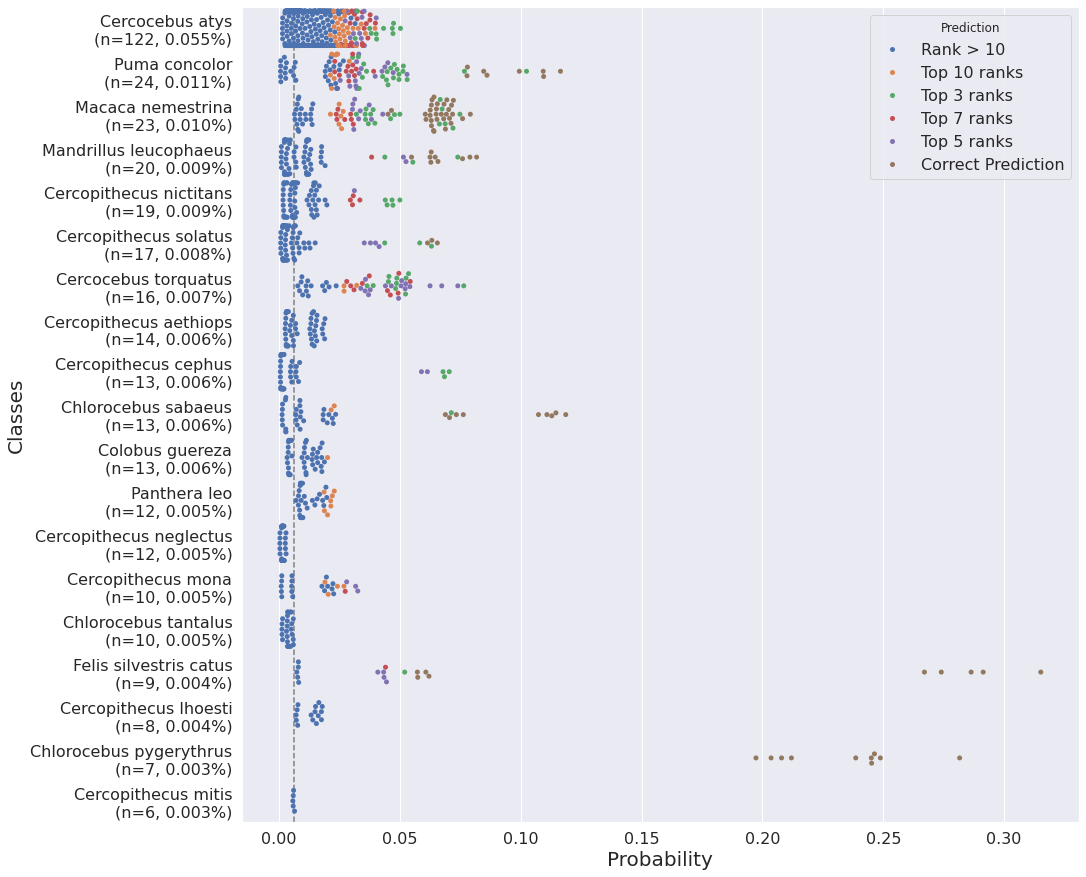

In [61]:
class_prob_df = analyze_all_way_fsl_results(output_file_path, auprc_file_path)

<Figure size 432x288 with 0 Axes>

<Figure size 2880x720 with 0 Axes>

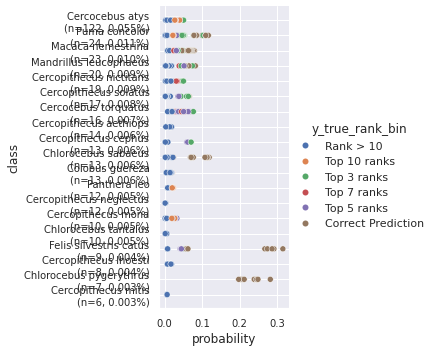

In [53]:
plt.clf()
plt.figure(figsize=(40, 10))
sns.set_theme()
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams.update({'font.size': 10})
sns.relplot(data=class_prob_df, x="probability", y="class",  hue="y_true_rank_bin")

#### 19-way

In [54]:
output_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv")
auprc_file_path =  os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20241010/host_multi/few_shot_learning/fsl_tr_w5s3q10_te_walls3q-1_tsk1e1b16itr5_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")

Number of unique classes in output_df = 19
Number of unique labels in output_df = 19


<Figure size 432x288 with 0 Axes>

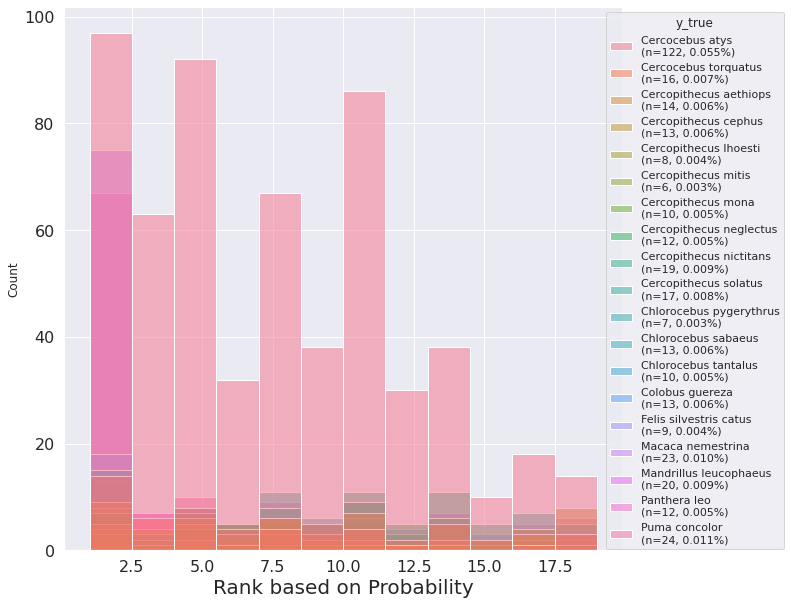

Number of IDV labels in output - 19
{'Cercocebus atys', 'Cercopithecus nictitans', 'Colobus guereza', 'Chlorocebus tantalus', 'Cercocebus torquatus', 'Chlorocebus sabaeus', 'Cercopithecus cephus', 'Macaca nemestrina', 'Cercopithecus neglectus', 'Felis silvestris catus', 'Mandrillus leucophaeus', 'Cercopithecus mona', 'Puma concolor', 'Cercopithecus mitis', 'Panthera leo', 'Cercopithecus lhoesti', 'Chlorocebus pygerythrus', 'Cercopithecus aethiops', 'Cercopithecus solatus'}
   probability            class y_true_rank_bin  y_true_rank
0     0.051410  Cercocebus atys     Top 7 ranks          6.0
1     0.036338  Cercocebus atys    Top 10 ranks          9.0
2     0.065292  Cercocebus atys     Top 7 ranks          6.0
3     0.021439  Cercocebus atys       Rank > 10         11.0
4     0.121066  Cercocebus atys     Top 3 ranks          2.0


/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 42.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Figure size 432x288 with 0 Axes>

/home/blessyantony/.local/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 41.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


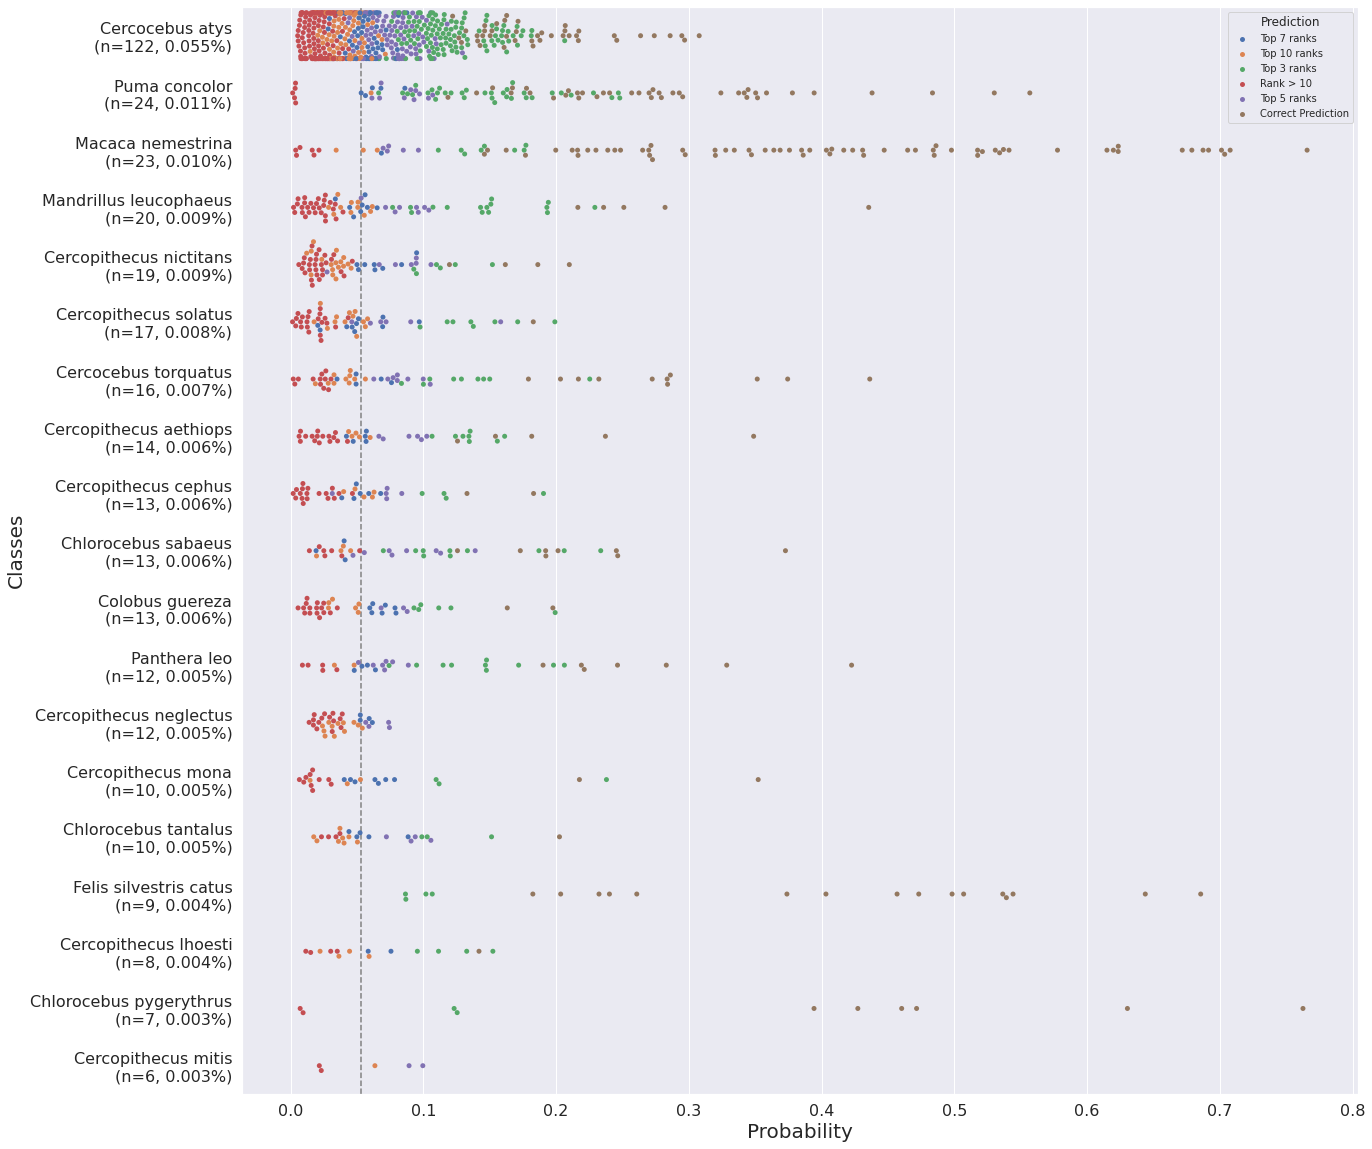

,probability,class,y_true_rank_bin,y_true_rank
0,0.051410,"Cercocebus atys\n(n=122, 0.055%)",Top 7 ranks,6.0
35,0.053198,"Cercocebus atys\n(n=122, 0.055%)",Top 10 ranks,8.0
36,0.120355,"Cercocebus atys\n(n=122, 0.055%)",Top 3 ranks,2.0
37,0.023598,"Cercocebus atys\n(n=122, 0.055%)",Rank > 10,11.0
38,0.045617,"Cercocebus atys\n(n=122, 0.055%)",Top 10 ranks,8.0
...,...,...,...,...
148,0.021602,"Cercopithecus mitis\n(n=6, 0.003%)",Rank > 10,12.0
148,0.089197,"Cercopithecus mitis\n(n=6, 0.003%)",Top 5 ranks,4.0
148,0.023072,"Cercopithecus mitis\n(n=6, 0.003%)",Rank > 10,15.0
148,0.063479,"Cercopithecus mitis\n(n=6, 0.003%)",Top 10 ranks,8.0


In [55]:
analyze_all_way_fsl_results(output_file_path, auprc_file_path)